In [1]:
import pandas as pd

# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

In [1]:
import warnings
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# 경고 무시
warnings.filterwarnings("ignore")

# 폰트 설정
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

data = pd.read_csv('data/final_merged_update_store_age_df.csv')

# 새로운 피처 추가
data['시간대_매출금액'] = data['시간대_매출금액']/data['유사_업종_점포_수']
data['편의점_밀도'] = data['유사_업종_점포_수']/data['영역_면적']

# 불필요한 컬럼 제거
data = data.drop(columns=['영역_면적', '상권_코드', '자치구_코드', '행정동_코드', '자치구_코드_명', '평일_유동인구_수_평균', '주말_유동인구_수_평균', '소득_구간_코드', '점포_수', '개업_율', '폐업_률', '프랜차이즈_점포_수', '상권_구분_코드_명'])

# 범주형 변수와 숫자형 변수 구분
cat_cols = ['기준_년', '기준_분기', '시간대', '상권_코드_명', '행정동_코드_명']
num_cols = data.columns.difference(cat_cols).tolist()


# 독립변수와 종속변수 분리
y = data.pop('시간대_매출금액')
X = data

# 독립변수 데이터 스케일링
# 변수 구분 코드에서 종속변수 제거
num_cols.remove('시간대_매출금액')

## 범주형 변수 더미화
X = pd.get_dummies(X, columns=cat_cols)

## 더미 변수화된 값이 불리언 형태로 나왔다면 0과 1로 변환
X.replace({True: 1, False: 0}, inplace=True)

## 숫자형 변수 정규화
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

def clean_feature_names(X):
    # 특수 문자를 제거하고 언더스코어(_)로 대체합니다.
    X.columns = [re.sub(r'\W+', '_', col) for col in X.columns]
    return X

# 데이터프레임 X의 특성 이름을 정제합니다.
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

# Box-Cox 변환 적용
y_train_boxcox, lambda_ = boxcox(y_train + 1)  # +1을 더하는 이유는 음수 값이 없도록 하기 위함
y_test_boxcox = boxcox(y_test + 1, lmbda=lambda_)

# 모델 학습 - LightGBM
lgbm_regression = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 범위 설정
param_grid = {
    'num_leaves': [25, 30, 35],
    'learning_rate': [0.12, 0.13, 0.14],
    'n_estimators': [375, 400, 425]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=lgbm_regression, param_grid=param_grid, cv=3)

# 모델 학습
grid_search.fit(X_train, y_train_boxcox)

# 최적의 모델로 예측 수행
best_lgbm_regression = grid_search.best_estimator_
y_pred_lgbm_grid_boxcox = best_lgbm_regression.predict(X_test)


# 예측 결과를 원래의 스케일로 되돌리기 위해 역 Box-Cox 변환 적용
y_pred_lgbm_grid = inv_boxcox(y_pred_lgbm_grid_boxcox, lambda_)

# 평가
def evaluate(y_true, y_pred):
    # MSE 계산
    mse = mean_squared_error(y_true, y_pred)
    
    # MAE 계산
    mae = mean_absolute_error(y_true, y_pred)
    
    # R-squared 계산
    r_squared = r2_score(y_true, y_pred)
    
    # RMSE 계산
    rmse = np.sqrt(mse)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'R-squared': r_squared,
        'RMSE': rmse
    }


evaluate(y_test, y_pred_lgbm_grid)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 114
[LightGBM] [Info] Start training from score 2342.044204
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 114
[LightGBM] [Info] Start training from score 2343.764855
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

{'MSE': 14902040989702.588,
 'MAE': 2348685.281146165,
 'R-squared': 0.9597078916616766,
 'RMSE': 3860316.1774267387}

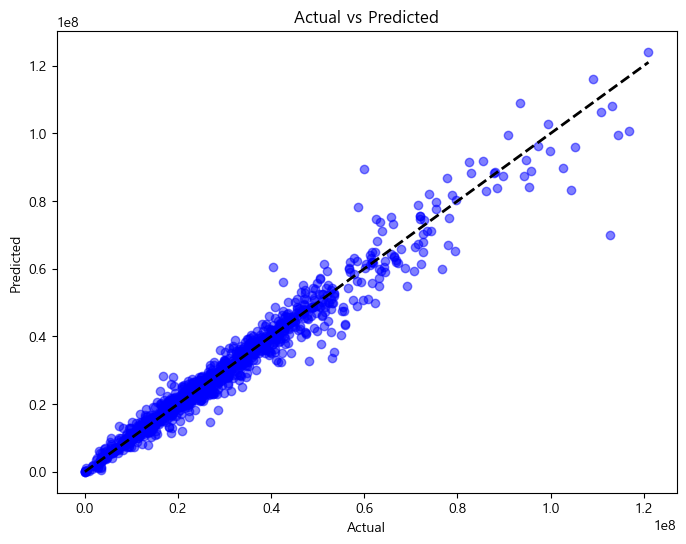

In [2]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lgbm_grid, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

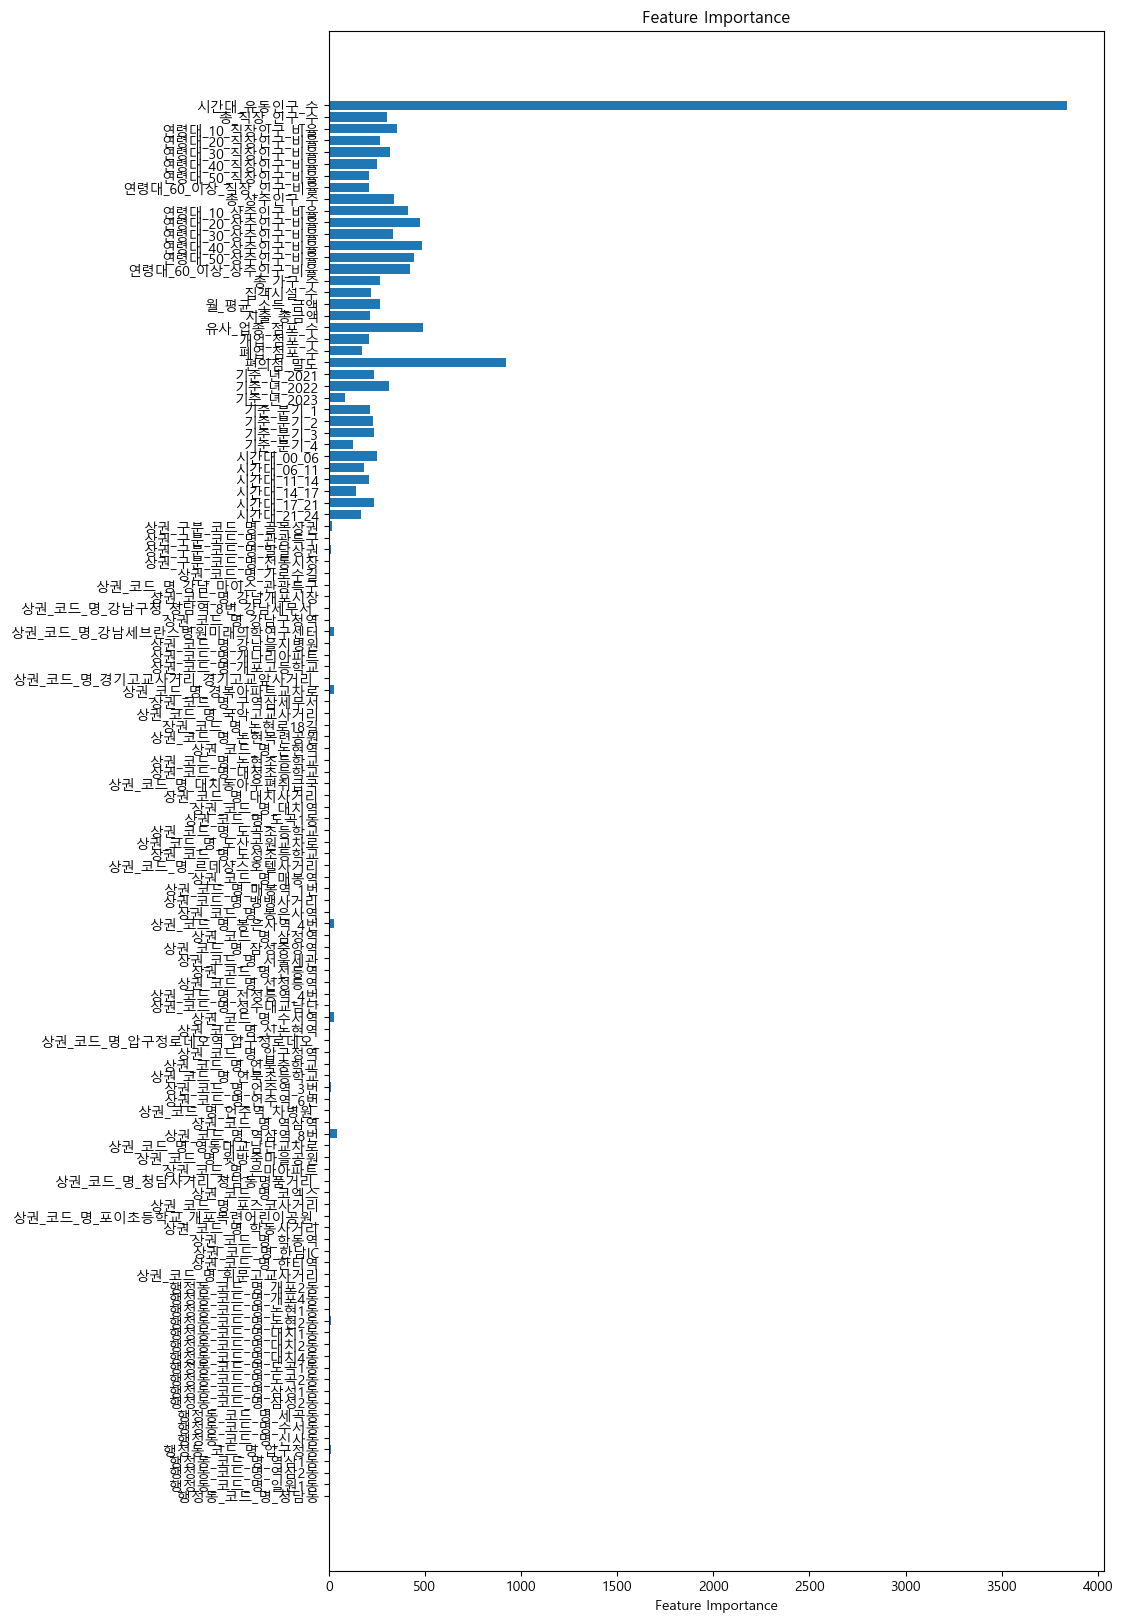

In [10]:
# 피처 중요도 시각화
plt.figure(figsize=(10, 20))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(X_train.columns)), X_train.columns)
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 상위 피처가 상단에 오도록 역순으로 설정
plt.show()


In [11]:
import warnings
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# 경고 무시
warnings.filterwarnings("ignore")

# 폰트 설정
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

data = pd.read_csv('data/final_merged_update_store_age_df.csv')

# 새로운 피처 추가
data['시간대_매출금액'] = data['시간대_매출금액']/data['유사_업종_점포_수']
data['편의점_밀도'] = data['유사_업종_점포_수']/data['영역_면적']

# 불필요한 컬럼 제거
data = data.drop(columns=['영역_면적', '상권_코드', '자치구_코드', '행정동_코드', '자치구_코드_명', '평일_유동인구_수_평균', '주말_유동인구_수_평균', '소득_구간_코드', '점포_수', '개업_율', '폐업_률', '프랜차이즈_점포_수', '행정동_코드_명'])

# 범주형 변수와 숫자형 변수 구분
cat_cols = ['기준_년', '기준_분기', '시간대', '상권_구분_코드_명', '상권_코드_명']
num_cols = data.columns.difference(cat_cols).tolist()


# 독립변수와 종속변수 분리
y = data.pop('시간대_매출금액')
X = data

# 독립변수 데이터 스케일링
# 변수 구분 코드에서 종속변수 제거
num_cols.remove('시간대_매출금액')

## 범주형 변수 더미화
X = pd.get_dummies(X, columns=cat_cols)

## 더미 변수화된 값이 불리언 형태로 나왔다면 0과 1로 변환
X.replace({True: 1, False: 0}, inplace=True)

## 숫자형 변수 정규화
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

def clean_feature_names(X):
    # 특수 문자를 제거하고 언더스코어(_)로 대체합니다.
    X.columns = [re.sub(r'\W+', '_', col) for col in X.columns]
    return X

# 데이터프레임 X의 특성 이름을 정제합니다.
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

# Box-Cox 변환 적용
y_train_boxcox, lambda_ = boxcox(y_train + 1)  # +1을 더하는 이유는 음수 값이 없도록 하기 위함
y_test_boxcox = boxcox(y_test + 1, lmbda=lambda_)

# 모델 학습 - LightGBM
lgbm_regression = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 범위 설정
param_grid = {
    'num_leaves': [25, 30, 35],
    'learning_rate': [0.12, 0.13, 0.14],
    'n_estimators': [375, 400, 425]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=lgbm_regression, param_grid=param_grid, cv=3)

# 모델 학습
grid_search.fit(X_train, y_train_boxcox)

# 최적의 모델로 예측 수행
best_lgbm_regression = grid_search.best_estimator_
y_pred_lgbm_grid_boxcox = best_lgbm_regression.predict(X_test)


# 예측 결과를 원래의 스케일로 되돌리기 위해 역 Box-Cox 변환 적용
y_pred_lgbm_grid = inv_boxcox(y_pred_lgbm_grid_boxcox, lambda_)

# 평가
def evaluate(y_true, y_pred):
    # MSE 계산
    mse = mean_squared_error(y_true, y_pred)
    
    # MAE 계산
    mae = mean_absolute_error(y_true, y_pred)
    
    # R-squared 계산
    r_squared = r2_score(y_true, y_pred)
    
    # RMSE 계산
    rmse = np.sqrt(mse)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'R-squared': r_squared,
        'RMSE': rmse
    }


evaluate(y_test, y_pred_lgbm_grid)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 99
[LightGBM] [Info] Start training from score 2342.044204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 99
[LightGBM] [Info] Start training from score 2343.764855
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2166
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 99
[LightGBM] [Info] Start 

{'MSE': 16251717596160.787,
 'MAE': 2450778.4167644484,
 'R-squared': 0.9560586387783506,
 'RMSE': 4031341.9101039777}